# Neural Style Transfer

> In this module, we approach a classic AI art algorithm

Adapted from:

- [https://youtu.be/PdNHkTLU2oQ?si=FxubIPL2CXlsEnWy&t=1233](https://youtu.be/PdNHkTLU2oQ?si=FxubIPL2CXlsEnWy&t=1233)

In [1]:
#| default_exp style_transfer

In [2]:
from functools import partial

import timm
import torch
import torch.nn.functional as F
import torchvision.transforms as T
from torch import nn, tensor

from slowai.learner import (
    DataLoaders,
    Learner,
    MetricsCB,
    ProgressCB,
    TrainCB,
    TrainLearner,
    def_device,
)
from slowai.utils import download_image, show_image, show_images

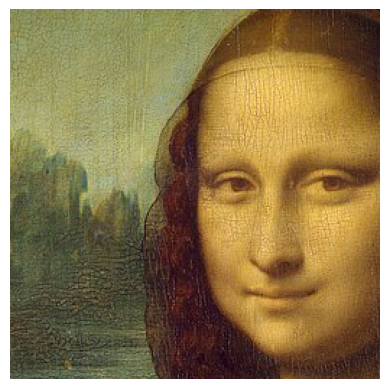

In [3]:
url = "https://upload.wikimedia.org/wikipedia/commons/thumb/e/ec/Mona_Lisa%2C_by_Leonardo_da_Vinci%2C_from_C2RMF_retouched.jpg/640px-Mona_Lisa%2C_by_Leonardo_da_Vinci%2C_from_C2RMF_retouched.jpg"
img = download_image(url)
xo, yo = 100, 100
img = img[:, xo : 256 + xo, yo : 256 + yo]
show_image(img.permute(1, 2, 0));

In [4]:
img.min(), img.max()

(tensor(0.), tensor(1.))

We can optimize the raw pixels, like any other parameter.

In [5]:
class DummyDataset:
    """Dataset that yields n iterations of dummy data"""

    def __init__(self, n):
        self.n = n

    def __len__(self):
        return self.n

    def __getitem__(self, idx):
        x, y = 0, 0
        return x, y


def get_dls(n):
    return DataLoaders(
        splits={"train": DummyDataset(n), "test": DummyDataset(1)}, nworkers=0
    )

In [6]:
class TensorModel(nn.Module):
    def __init__(self, tensor_):
        super().__init__()
        self.tensor_ = nn.Parameter(tensor_.clone())

    def forward(self, *args, **kwargs):
        return self.tensor_

In [7]:
m = TensorModel(tensor_=torch.rand_like(img))
m().shape

torch.Size([3, 256, 256])

In [8]:
class ImgOptCb(TrainCB):
    def __init__(self, target):
        self.target = target
        self.intermediates = []

    def predict(self, learn):
        learn.preds = learn.model()
        self.intermediates.append(learn.preds.clone())

    def get_loss(self, learn):
        learn.loss = learn.loss_func(learn.preds, self.target)

In [9]:
def optimize_noise_to_target(noise_model, n, target, lr=0.001):
    dls = get_dls(n)
    img_opt_cb = ImgOptCb(target)
    cbs = [img_opt_cb, ProgressCB(plot=True)]
    Learner(
        noise_model,
        dls,
        F.mse_loss,
        lr=lr,
        cbs=cbs,
        opt_func=torch.optim.Adam,
    ).fit(1)
    return noise_model.tensor_.clip(0, 1), img_opt_cb.intermediates

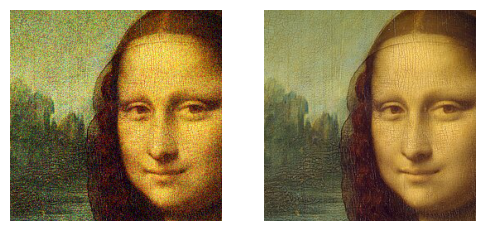

In [10]:
denoise, intermediates = optimize_noise_to_target(
    TensorModel(tensor_=torch.rand_like(img)),
    250,
    img,
    lr=1e-1,
)
show_images([denoise, img])

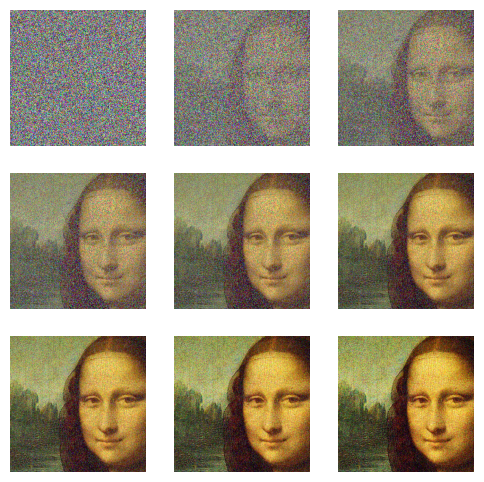

In [11]:
show_images([i.clip(0, 1) for i in intermediates], figsize=(6, 6))

This isn't interesting on its own, but starts to become interesting when we incorporate the pretrained feature extractors such as VGG16. This gives us a richer representation than the raw pixels that we can manipulate.

[Here is a classic article](https://distill.pub/2017/feature-visualization/) on the discriminative features that these models learn.

VGG16 is similar to the pre-resnet model we implemented for FashionMNIST.

![https://miro.medium.com/v2/resize:fit:720/format:webp/1*NNifzsJ7tD2kAfBXt3AzEg.png](https://miro.medium.com/v2/resize:fit:720/format:webp/1*NNifzsJ7tD2kAfBXt3AzEg.png)

In [12]:
vgg16 = timm.create_model("vgg16", pretrained=True).to(def_device)

In [13]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

To use VGG16, we need to normalize for each color channel __with the same constants that the model was trained with__.

In [14]:
imagenet_mean = tensor([0.485, 0.456, 0.406])
imagenet_std = tensor([0.229, 0.224, 0.225])

In [15]:
def normalize_imagenet(img):
    i = img.clone()
    i -= imagenet_mean[:, None, None]
    i /= imagenet_std[:, None, None]
    return i

In [16]:
img.shape

torch.Size([3, 256, 256])

<Axes: >

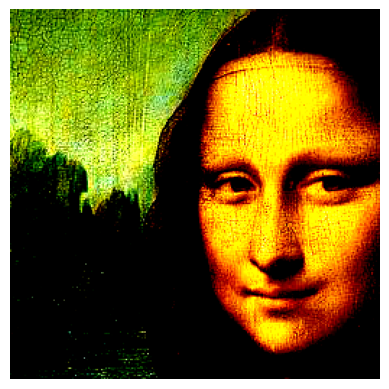

In [17]:
nimg = normalize_imagenet(img)
show_image(nimg.clip(0, 1))

We can also use the PyTorch version

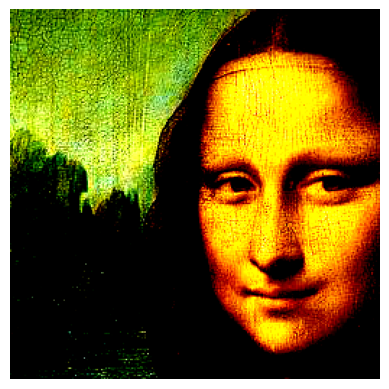

In [18]:
pt_normalize_imagenet = T.Normalize(imagenet_mean, imagenet_std)
show_image(pt_normalize_imagenet(img).clip(0, 1));

So, how do we use this normalized image to extract their features?

In [19]:
def calculate_features_vgg16(vgg16, imgs, target_layers=(18, 25)):
    x = pt_normalize_imagenet(imgs).to(def_device)
    features = []
    for i, layer in enumerate(vgg16.features[: max(target_layers) + 1]):
        x = layer(x)
        if i in target_layers:
            features.append(x.clone())
    return features

In [20]:
embeddings = calculate_features_vgg16(vgg16, nimg)
embeddings[0].shape

torch.Size([512, 32, 32])

In [21]:
# Homework: Implement a hook to capture intermediate representations

We can implement a loss function that computes the differences in __feature space__.

In [22]:
class ContentLoss:
    def __init__(
        self,
        target_img,
        target_layers=(18, 25),  # out of 30
        vgg=timm.create_model("vgg16", pretrained=True).to(def_device),
    ):
        self.featurize = partial(
            calculate_features_vgg16, vgg, target_layers=target_layers
        )
        with torch.no_grad():
            self.tgt = self.featurize(target_img)

    def __call__(self, img, _):
        inp = self.featurize(img)
        return sum(F.mse_loss(f1, f2) for f1, f2 in zip(inp, self.tgt))

In [23]:
def optimize_features_to_target(
    noise_model,
    n,
    target,
    lr=0.001,
    epochs=5,
    target_layers=(18, 25),
):
    intermediates = []
    for _ in range(epochs):
        TrainLearner(
            noise_model,
            get_dls(n // epochs),
            ContentLoss(target, target_layers=target_layers),
            lr=lr,
            opt_func=torch.optim.Adam,
        ).fit(1)
        i = noise_model.tensor_.clone().detach().clip(0, 1)
        intermediates.append(i)
    return intermediates

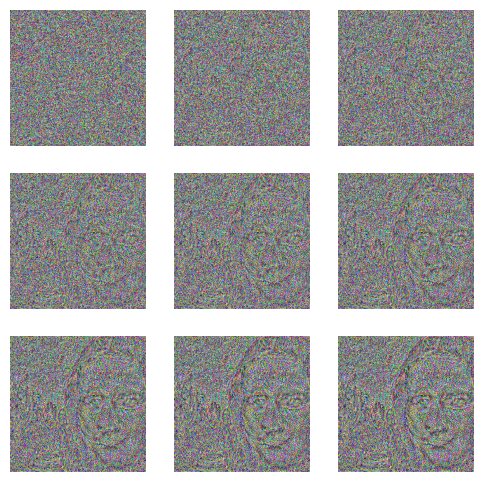

In [24]:
nm = TensorModel(tensor_=torch.rand_like(img))
out = [torch.rand_like(img), *optimize_features_to_target(nm, 1000, nimg, 1e-2, 8)]
show_images(out, figsize=(6, 6))

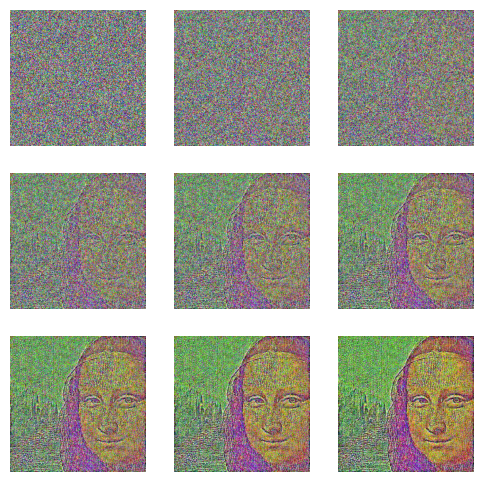

In [25]:
nm = TensorModel(tensor_=torch.rand_like(img))
out = optimize_features_to_target(nm, 1000, nimg, 1e-2, 8, target_layers=(1,))
show_images([torch.rand_like(img), *out], figsize=(6, 6))

## Gram Loss

We don't want to just transfer the spatial feature maps. We want something more abstract: **style**.

This is where the **Gram matrix** comes in. The gram matrix uses an intermediate represention, $X$, where the magnitude of a feature basis is the row and the pixel ID in the column. By taking $X \cdot X^T$, we get the covariance matrix of the feature activations, which we call the Gram matrix.

![](https://api.wandb.ai/files/johnowhitaker/images/projects/37105622/7b9dff33.png)

[Paper here.](https://arxiv.org/abs/1508.06576)

In [26]:
def calculate_grams_vgg16(vgg16, imgs, target_layers=(18, 25)):
    feats = calculate_features_vgg16(vgg16, imgs, target_layers)
    grams_ = []
    for f in feats:
        c, h, w = f.shape
        g = torch.einsum("chw, dhw -> cd", f, f)
        gnorm = g / (h * w)
        grams_.append(gnorm)
    return grams_

In [27]:
class GramLoss:
    def __init__(
        self,
        target_img,
        target_layers=(18, 25),  # out of 30
        vgg=timm.create_model("vgg16", pretrained=True).to(def_device),
    ):
        self.gram = partial(calculate_grams_vgg16, vgg, target_layers=target_layers)
        with torch.no_grad():
            self.tgt = self.gram(target_img)

    def __call__(self, img, _):
        inp = self.gram(img)
        return sum(F.mse_loss(f1, f2) for f1, f2 in zip(inp, self.tgt))

In [28]:
def optimize_gram_to_target(
    noise_model,
    n,
    target,
    lr=0.001,
    epochs=5,
    target_layers=(18, 25),
):
    intermediates = []
    for _ in range(epochs):
        TrainLearner(
            noise_model,
            get_dls(n // epochs),
            GramLoss(target, target_layers=target_layers),
            lr=lr,
            opt_func=torch.optim.Adam,
        ).fit(1)
        i = noise_model.tensor_.clone().detach().clip(0, 1)
        intermediates.append(i)
    return intermediates

<Axes: >

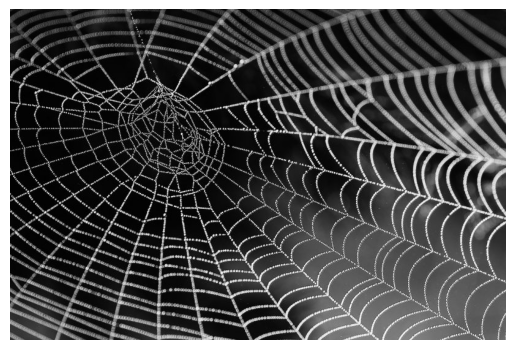

In [53]:
spider_web = "https://insideecology.com/wp-content/uploads/2018/06/spider-web-with-water-beads-921039_1280-810x540.jpg"
show_image(download_image(spider_web))

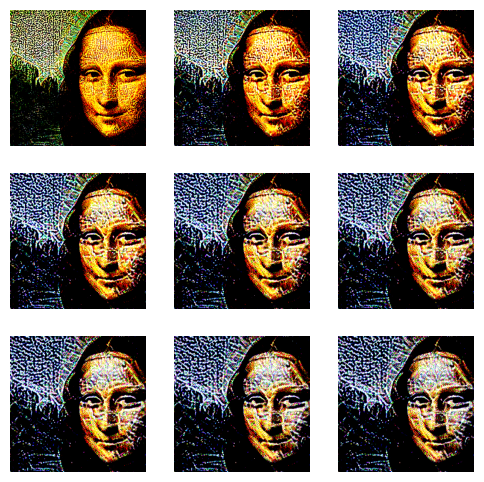

In [59]:
def style_transfer(from_, to_):
    if isinstance(from_, str):
        from_ = pt_normalize_imagenet(download_image(from_))
    if isinstance(to_, str):
        to_ = pt_normalize_imagenet(download_image(to_))
    nm = TensorModel(tensor_=from_)
    return optimize_gram_to_target(nm, 2000, to_, 0.1, 9, target_layers=(2, 18, 25))


show_images(style_transfer(nimg, spider_web), figsize=(6, 6))

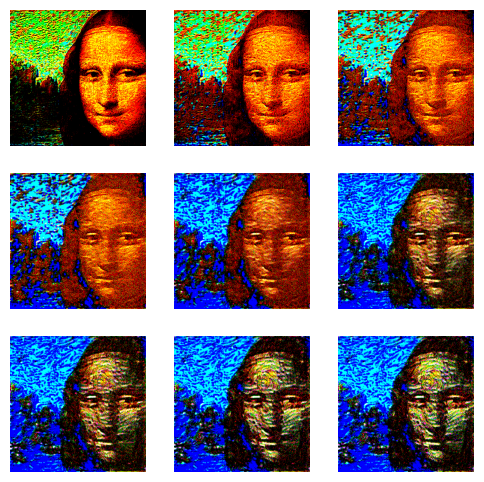

In [64]:
starry_night = "https://sanctuarymentalhealth.org/wp-content/uploads/2021/03/The-Starry-Night-1200x630-1-979x514.jpg"
show_images(style_transfer(nimg, starry_night), figsize=(6, 6))

In [31]:
#| hide
import nbdev

nbdev.nbdev_export()